Four FASTQ files are placed on Blackboard:
<blockquote>
XI1_ATCACG_L001_R1_001.fastq
<br>
XI1_ATCACG_L001_R2_001.fastq
    <br>
RETT-1_S1_L001_R1_001.fastq
    <br>
RETT-1_S1_L001_R2_001.fastq
</blockquote>
These are next generation sequencing files from a paired-end run. The XI1 reads are mostly 250 base
pairs long, the RETT reads are mostly 150 base pairs long. Complicating the assignment, there are a few
reads that are a few bases shorter or longer than 250 or 150.

# 1
Write a Python function that counts the number of reads with the same, shorter and longer
length than expected. For each of the four files print the out. Compare the results and describe
your finding [3pt].

In [2]:
filenames = ["XI1_ATCACG_L001_R1_001.fastq", "XI1_ATCACG_L001_R2_001.fastq", 
             "RETT-1_S1_L001_R1_001.fastq", "RETT-1_S1_L001_R2_001.fastq"]
expectedValues = {i:j for i,j in zip(filenames, [250, 250, 150, 150])}
print(filenames)
print(expectedValues)

['XI1_ATCACG_L001_R1_001.fastq', 'XI1_ATCACG_L001_R2_001.fastq', 'RETT-1_S1_L001_R1_001.fastq', 'RETT-1_S1_L001_R2_001.fastq']
{'XI1_ATCACG_L001_R1_001.fastq': 250, 'XI1_ATCACG_L001_R2_001.fastq': 250, 'RETT-1_S1_L001_R1_001.fastq': 150, 'RETT-1_S1_L001_R2_001.fastq': 150}


In [3]:
def qualityTranform(qualityLine):
    qualityScore = []
    for char in qualityLine:
        qualityScore.append(ord(char) - 33)
    return qualityScore
    #return np.array(qualityScore) #if you want to return a numpy array instead
def qualityTranform_oneline(qualityLine):
    return list(map(lambda x: ord(x) - 33, qualityLine))
    
def readFastq(filename):
    sequences = []
    qualities = []
    with open(filename, "r") as fin:
        lineNumber = 0
        for line in fin:
            if lineNumber % 4 == 1:
                sequences.append(line.strip())
            elif lineNumber % 4 == 3:
                qualities.append(qualityTranform(line.strip()))
            lineNumber += 1
    return sequences, qualities

def countLength(sequences, expectedValue):
    shorter = 0 
    same = 0
    longer = 0 
    for seq in sequences:
        if len(seq) == expectedValue:
            same += 1
        elif len(seq) < expectedValue:
            shorter += 1
        else:
            longer += 1
    return shorter, same, longer


In [4]:
allSeqs = {}
allQualities = {}
for i in range(4):
    seqs, qualities = readFastq(filenames[i])
    allSeqs[filenames[i]] = seqs
    allQualities[filenames[i]] = qualities
    print(filenames[i])
    print("shorter: %d, same: %d, longer: %d" % (countLength(seqs, expectedValues[filenames[i]])))

XI1_ATCACG_L001_R1_001.fastq
shorter: 0, same: 10000, longer: 0
XI1_ATCACG_L001_R2_001.fastq
shorter: 0, same: 10000, longer: 0
RETT-1_S1_L001_R1_001.fastq
shorter: 970, same: 1943, longer: 7087
RETT-1_S1_L001_R2_001.fastq
shorter: 905, same: 2056, longer: 7039


# 2

Write a Python function that for each of the positions 1 to 250 (or 1 to 150) will compute the
fraction of reads in the file with quality scores greater than or equal to 30 at that position. For
each of the four files plot the output. Compare the results and describe your finding [5pt].
<br>

HINT: for those reads that are shorter read what is there, while for those reads that are longer,
read the first 250 (or 150) bases (and ignore the rest)

In [17]:
#Using basic python data structures
def countFraction(qualities, length, value):
    countValid = [0] * length
    countGood = [0] * length
    fraction = [0] * length
    for quality in qualities:
        # quality : [38, 38, ...., 10, 12]
        for i in range(0, min(len(quality), length)):
            countValid[i] += 1
            if quality[i] >= value:
                countGood[i] += 1
    for i in range(length):
        fraction[i] = countGood[i] / countValid[i]
    return fraction

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#using numpy array
def getNumpyMatrix(qualities, length):
    scores = np.empty(shape = (len(qualities), length))
    scores[:] = -np.inf
    for i in range(len(qualities)):
        currentLength = min(length, len(qualities[i]))
        scores[i, :currentLength] = qualities[i][:currentLength]
    return scores

def countFraction_numpy(qualities, length, value):
    scores = getNumpyMatrix(qualities, length)
    countGood = np.sum(scores >= value, axis = 0)
    countAll = np.sum(scores != -np.inf, axis = 0)
    return countGood / countAll

In [16]:
filename = filenames[0]
scores = getNumpyMatrix(allQualities[filename], 250)
print(scores)
print(np.sum(scores >= 30, axis = 1).shape)

[[13. 27. 13. ...  2.  2.  2.]
 [27. 27. 27. ... 22. 22. 22.]
 [ 2. 27. 27. ...  2.  2.  2.]
 ...
 [38. 38. 38. ... 38. 38. 22.]
 [13. 27. 38. ...  2.  2.  2.]
 [38. 38. 38. ... 38.  2.  2.]]
(10000,)


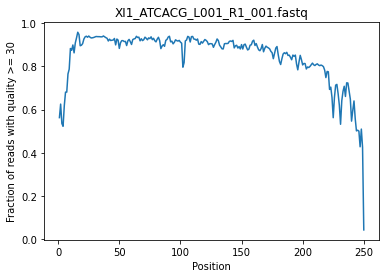

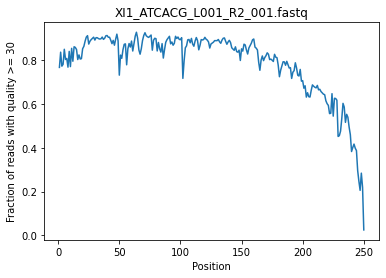

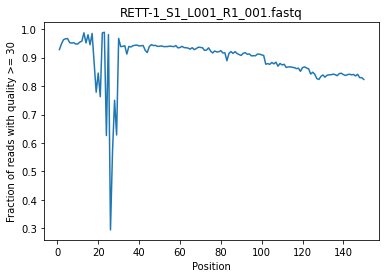

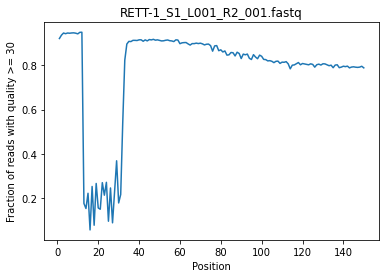

In [21]:
for filename in filenames:
    x = range(1, expectedValues[filename]+1)
    #y = countFraction(allQualities[filename], expectedValues[filename], 30)
    y = countFraction_numpy(allQualities[filename], expectedValues[filename], 30)
    plt.plot(x, y)
    plt.title(filename)
    plt.xlabel("Position")
    plt.ylabel("Fraction of reads with quality >= 30")
    plt.show()

# 3 

Write another function that for k from 0 to 250 (or from 0 to 150) will count the number of
reads in the file with exactly k positions with quality scores greater than or equal to 30. For each
of the four files plot the output [Bonus 2pt].
<br>

HINT: outputs number of reads with k positions with quality >= 30 for k=0 to 250 (or 150). Plot k
on x-axis and number of reads on y-axis.

In [23]:
#Python built-in
def countSeqGreaterK(qualities, length, value):
    countperK = [0] * (length + 1)
    for quality in qualities:
        charCount = 0
        for i in range(min(len(quality), length)):
            if quality[i] >= value:
                charCount += 1
        countperK[charCount] += 1
    return range(length+1), countperK

#Numpy
def countSeqGreaterK_numpy(qualities, length, value):
    scores = getNumpyMatrix(qualities, length)
    countGood = np.sum(scores >= value, axis = 1)
    unique, counts = np.unique(countGood, return_counts=True)
    return unique, counts

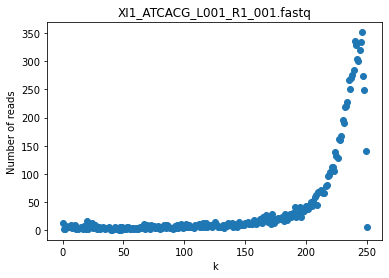

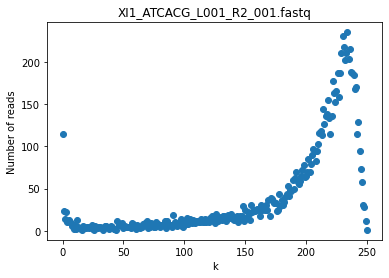

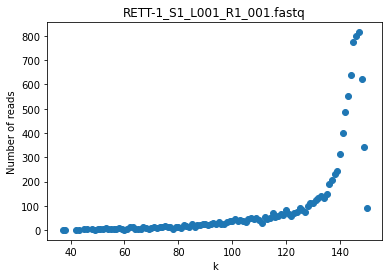

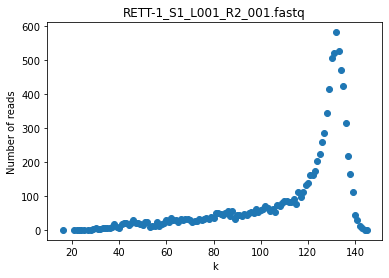

In [25]:
for filename in filenames:
    #x, y = countSeqGreaterK(allQualities[filename], expectedValues[filename], 30)
    x, y = countSeqGreaterK_numpy(allQualities[filename], expectedValues[filename], 30)
    plt.scatter(x, y)
    plt.title(filename)
    plt.xlabel("k")
    plt.ylabel("Number of reads")
    plt.show()

In [30]:
def func(x):
    return x*2
a = [1,2,3,4,5,9,10]

for b in map(func, a):
    print(b)

2
4
6
8
10
18
20
